In [11]:
%load_ext autoreload
%autoreload 2

import sys, importlib, pickle, gc
sys.path.append('../..')
sys.modules['src.simulation'] = importlib.import_module('src.logit_graph.simulation')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

from src.logit_graph.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [13]:
data_directory = f'../../data/twitch/'
os.listdir(data_directory)

['RU',
 'ENGB',
 'citing.txt',
 'PTBR',
 'DE',
 'README.txt',
 'FR',
 'ES',
 'graphs_processed']

In [14]:
from src.logit_graph.simulation import estimate_sigma_many

n_repeats = 1
max_edges = None
max_non_edges = None

l1_wt = 1 # The L1 weight for the regularization
alpha = 0 # The regularization parameter

seed = 42

# Collect Twitch processed graph files
graphs_processed_dir = os.path.join(data_directory, 'graphs_processed')
region_files = [f for f in os.listdir(graphs_processed_dir) if f.endswith('_graph.edges')]
region_files = sorted(region_files)


optimal_d = {'ENGB': 1, 'FR': 0, 'DE': 1, 'ES': 1, 'PTBR': 1, 'RU': 0}


### REpeat n times the estimation

In [200]:
records = []
#files_to_analyse = region_files[-2:]
files_to_analyse = region_files
print(files_to_analyse)

for file_name in files_to_analyse:
    region = file_name.replace('_graph.edges', '')
    file_path = os.path.join(graphs_processed_dir, file_name)
    
    # Use the optimal d for this region
    d_for_region = optimal_d.get(region, an_d)
    print(f"Estimating sigmas for region={region} from {file_path} with d={d_for_region}")

    G = nx.read_edgelist(file_path, nodetype=int)
    sigmas = estimate_sigma_many(
        G,
        d=d_for_region,
        n_repeats=n_repeats,
        max_edges=max_edges,
        max_non_edges=max_non_edges,
        l1_wt=l1_wt,
        alpha=alpha,
        seed=seed,
        verbose=False,
    )

    for idx, s in enumerate(sigmas):
        records.append({
            'region': region,
            'd': d_for_region,
            'repeat_index': idx,
            'sigma': float(s),
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
        })

['DE_graph.edges', 'ENGB_graph.edges', 'ES_graph.edges', 'FR_graph.edges', 'PTBR_graph.edges', 'RU_graph.edges']
Estimating sigmas for region=DE from ../../data/twitch/graphs_processed/DE_graph.edges with d=1


  0%|          | 0/1 [01:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
sigma_df = pd.DataFrame(records)
run_dir = 'runs'
os.makedirs(run_dir, exist_ok=True)
out_path = os.path.join(run_dir, f'twitch_sigma_estimates_d_optimal_N{n_repeats}.csv')
sigma_df.to_csv(out_path, index=False)
print(f"Saved sigma estimates to {out_path}")
sigma_df.head()


Saved sigma estimates to runs/twitch_sigma_estimates_d1_N50.csv


,region,d,repeat_index,sigma,num_nodes,num_edges
0,RU,1,0,-1.757861,4385,37304
1,RU,1,1,-1.762314,4385,37304
2,RU,1,2,-1.767284,4385,37304
3,RU,1,3,-1.752017,4385,37304
4,RU,1,4,-1.758021,4385,37304


In [ ]:
'finish simulation 2313213'

'finish simulation'

### running the anova

In [134]:
import os
import pandas as pd
from scipy import stats

# Match the save path used in the dataset notebook
an_d = [0, 1]
n_repeats = 50
run_dir = os.path.join('runs')


dfs = []
for an_d in [0, 1]:
    filename = f'twitch_sigma_estimates_d{an_d}_N{n_repeats}.csv'
    path = os.path.join(run_dir, filename)
    print(f"Loading: {path}")
    df = pd.read_csv(path)
    dfs.append(df)

Loading: runs/twitch_sigma_estimates_d0_N50.csv
Loading: runs/twitch_sigma_estimates_d1_N50.csv


In [135]:
df = pd.concat(dfs)
#subset = df[df['d'] == an_d].copy()

In [136]:
df.head()

,region,d,repeat_index,sigma,num_nodes,num_edges
0,RU,0,0,-1.752862,4385,37304
1,RU,0,1,-1.785105,4385,37304
2,RU,0,2,-1.765568,4385,37304
3,RU,0,3,-1.765380,4385,37304
4,RU,0,4,-1.793135,4385,37304


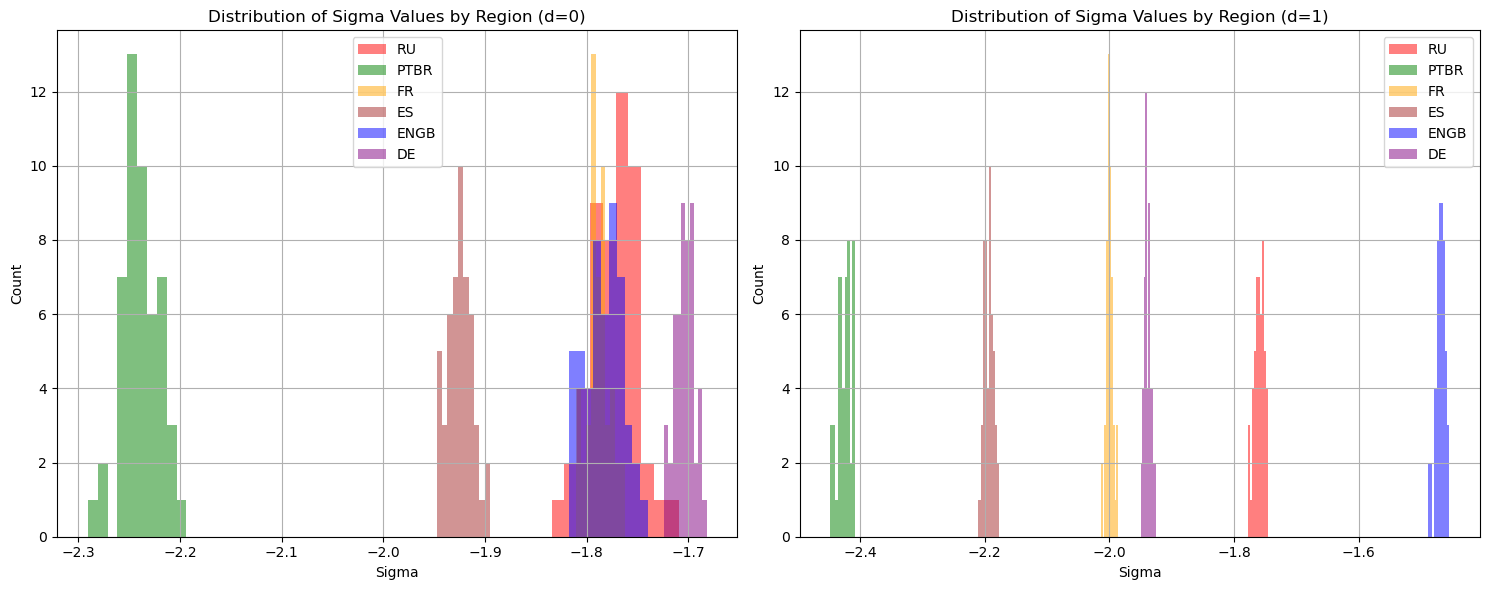

In [137]:
# Create histogram of sigmas by region and d
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each region
region_colors = {
    'RU': 'red',
    'ENGB': 'blue', 
    'PTBR': 'green',
    'DE': 'purple',
    'FR': 'orange',
    'ES': 'brown'
}

# Plot d=0 data
for region in df['region'].unique():
    region_data = df[(df['region'] == region) & (df['d'] == 0)]['sigma']
    ax1.hist(region_data, alpha=0.5,
            color=region_colors[region],
            label=region,
            bins=10)

#ax1.set_yscale('log')
ax1.set_xlabel('Sigma')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Sigma Values by Region (d=0)')
ax1.legend()
ax1.grid(True)

# Plot d=1 data
for region in df['region'].unique():
    region_data = df[(df['region'] == region) & (df['d'] == 1)]['sigma']
    ax2.hist(region_data, alpha=0.5,
            color=region_colors[region], 
            label=region,
            bins=10)

#ax2.set_yscale('log')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Sigma Values by Region (d=1)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [139]:
# Prepare groups by region and d
groups = df.groupby(['region', 'd'])['sigma'].apply(list)
regions = list(groups.index)

In [158]:
# Perform pairwise ANOVA tests for each d value
pmatrix = {}
for d in df['d'].unique():
    values = [groups[r] for r in regions if r[1] == d]
    region_names = [r[0] for r in regions if r[1] == d]
    n = len(region_names)
    
    # Create matrix to store p-values
    p_matrix = np.zeros((n, n))
    
    # Perform pairwise comparisons
    for i in range(n):
        for j in range(i+1, n):
            F, p = stats.f_oneway(values[i], values[j])
            p_matrix[i,j] = p
            p_matrix[j,i] = p
    
    # Set diagonal to 1
    np.fill_diagonal(p_matrix, 1.0)
    
    print(f"\nPairwise ANOVA p-values for d={d}:")
    print("Regions:", region_names)
    print(p_matrix)
    pmatrix[d] = p_matrix


Pairwise ANOVA p-values for d=0:
Regions: ['DE', 'ENGB', 'ES', 'FR', 'PTBR', 'RU']
[[1.00000000e+000 2.39562848e-047 1.92541501e-101 5.51389395e-063
  2.32791918e-126 8.99101175e-036]
 [2.39562848e-047 1.00000000e+000 2.03844359e-067 1.32950711e-001
  1.63616519e-109 1.36799372e-002]
 [1.92541501e-101 2.03844359e-067 1.00000000e+000 5.53203984e-078
  2.84463204e-101 1.02132778e-063]
 [5.51389395e-063 1.32950711e-001 5.53203984e-078 1.00000000e+000
  3.53846431e-117 6.53345537e-005]
 [2.32791918e-126 1.63616519e-109 2.84463204e-101 3.53846431e-117
  1.00000000e+000 2.75245710e-105]
 [8.99101175e-036 1.36799372e-002 1.02132778e-063 6.53345537e-005
  2.75245710e-105 1.00000000e+000]]

Pairwise ANOVA p-values for d=1:
Regions: ['DE', 'ENGB', 'ES', 'FR', 'PTBR', 'RU']
[[1.00000000e+000 4.56615272e-154 2.97664299e-126 1.44307047e-075
  3.64911057e-145 8.96383744e-112]
 [4.56615272e-154 1.00000000e+000 8.68161817e-166 8.35059157e-160
  1.64875917e-170 1.87200430e-127]
 [2.97664299e-126 8.681

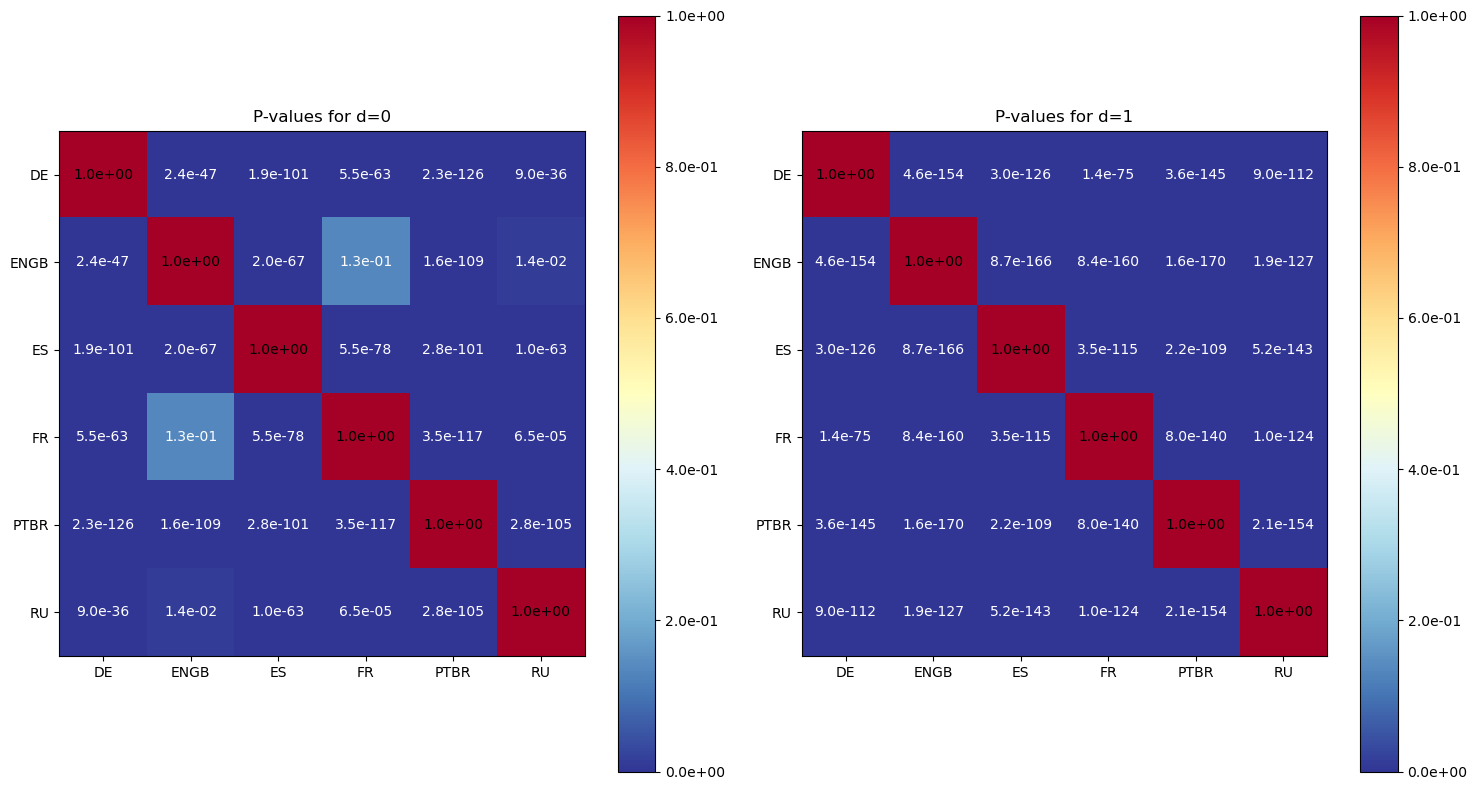

In [164]:
# Create a figure with subplots for d=0 and d=1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot heatmap for d=0
im1 = ax1.imshow(pmatrix[0], cmap='RdYlBu_r')  # Red-Yellow-Blue colormap, reversed
ax1.set_title('P-values for d=0')

# Add colorbar with scientific notation
cbar1 = plt.colorbar(im1, ax=ax1, format='%.1e')

# Set ticks and labels for d=0
region_names_d0 = [r[0] for r in regions if r[1] == 0]
ax1.set_xticks(np.arange(len(region_names_d0)))
ax1.set_yticks(np.arange(len(region_names_d0)))
ax1.set_xticklabels(region_names_d0)
ax1.set_yticklabels(region_names_d0)

# Add value annotations for d=0 with conditional text color
for i in range(len(region_names_d0)):
    for j in range(len(region_names_d0)):
        value = pmatrix[0][i, j]
        # White text for dark background, black text for light background
        text_color = 'white' if value < 0.5 else 'black'
        text = ax1.text(j, i, f'{value:.1e}',
                       ha='center', va='center', color=text_color)

# Plot heatmap for d=1
im2 = ax2.imshow(pmatrix[1], cmap='RdYlBu_r')  # Red-Yellow-Blue colormap, reversed
ax2.set_title('P-values for d=1')

# Add colorbar with scientific notation
cbar2 = plt.colorbar(im2, ax=ax2, format='%.1e')

# Set ticks and labels for d=1
region_names_d1 = [r[0] for r in regions if r[1] == 1]
ax2.set_xticks(np.arange(len(region_names_d1)))
ax2.set_yticks(np.arange(len(region_names_d1)))
ax2.set_xticklabels(region_names_d1)
ax2.set_yticklabels(region_names_d1)

# Add value annotations for d=1 with conditional text color
for i in range(len(region_names_d1)):
    for j in range(len(region_names_d1)):
        value = pmatrix[1][i, j]
        # White text for dark background, black text for light background
        text_color = 'white' if value < 0.5 else 'black'
        text = ax2.text(j, i, f'{value:.1e}',
                       ha='center', va='center', color=text_color)

plt.tight_layout()
plt.show()

In [151]:
# quick summary per region and d
summary = df.groupby(['region', 'd'])['sigma'].agg(['mean', 'std', 'count'])
display(summary)


mean       std  count
region d                           
DE     0 -1.703793  0.009422     50
       1 -1.938634  0.005627     50
ENGB   0 -1.783511  0.018528     50
       1 -1.468537  0.007519     50
ES     0 -1.924475  0.011984     50
       1 -2.193535  0.008022     50
FR     0 -1.788165  0.011333     50
       1 -1.999533  0.005420     50
PTBR   0 -2.239080  0.018234     50
       1 -2.425632  0.010593     50
RU     0 -1.773010  0.023052     50
       1 -1.759796  0.007869     50

In [152]:
# Get summary for d=1 and sort by mean sigma value
summary_sorted = df[df['d']==1].groupby('region')['sigma'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
display(summary_sorted)


,mean,std,count
region,,,
ENGB,-1.468537,0.007519,50
RU,-1.759796,0.007869,50
DE,-1.938634,0.005627,50
FR,-1.999533,0.005420,50
ES,-2.193535,0.008022,50
PTBR,-2.425632,0.010593,50


In [154]:
'finish all analysis'

'finish all analysis'

### Get the anova from the report

In [19]:
import sys
from src.logit_graph.simulation import estimate_sigma_only
optimal_d = {'ENGB': 1, 'FR': 0, 'DE': 1, 'ES': 1, 'PTBR': 1, 'RU': 0}

records = []
files_to_analyse = region_files[::-1]
print(files_to_analyse)

for file_name in files_to_analyse:
    region = file_name.replace('_graph.edges', '')
    file_path = os.path.join(graphs_processed_dir, file_name)
    print(f"Estimating sigmas for region={region} from {file_path}")

    G = nx.read_edgelist(file_path, nodetype=int)
    an_d = optimal_d[region]
    sigma, report = estimate_sigma_only(graph_input=G, d=an_d, max_edges=None, max_non_edges=None, l1_wt=1, alpha=0, random_state=None, verbose=True)
    records.append({
        'region': region,
        'd': an_d,
        'report': report,
        'sigma': sigma,
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
    })

['RU_graph.edges', 'PTBR_graph.edges', 'FR_graph.edges', 'ES_graph.edges', 'ENGB_graph.edges', 'DE_graph.edges']
Estimating sigmas for region=RU from ../../data/twitch/graphs_processed/RU_graph.edges
Estimating sigmas for region=PTBR from ../../data/twitch/graphs_processed/PTBR_graph.edges
Estimating sigmas for region=FR from ../../data/twitch/graphs_processed/FR_graph.edges
Estimating sigmas for region=ES from ../../data/twitch/graphs_processed/ES_graph.edges
Estimating sigmas for region=ENGB from ../../data/twitch/graphs_processed/ENGB_graph.edges
Estimating sigmas for region=DE from ../../data/twitch/graphs_processed/DE_graph.edges


In [20]:
records[0]['report'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                74608
Model:                          Logit   Df Residuals:                    74605
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                  0.3714
Time:                        19:49:58   Log-Likelihood:                -32508.
converged:                       True   LL-Null:                       -51714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7836      0.015   -119.417      0.000      -1.813      -1.754
x1             0.0165      0.000     70.723      0.000       0.016       0.017
x2             0.0417      0.001     77.882      0.000       0.041       0.043
==============================================================================
"""

In [21]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# 1) Collect intercept (const) and its SE from each fit
rows = []
for r in records:
    res = r['report']  # statsmodels Logit regularized results
    # intercept value
    try:
        const = float(res.params['const'])
    except Exception:
        const = float(res.params[0])
    # intercept SE (fallback via cov_params if needed)
    try:
        se_const = float(res.bse['const'])
    except Exception:
        try:
            se_const = float(res.bse[0])
        except Exception:
            se_const = float(np.sqrt(np.asarray(res.cov_params())[0, 0]))

    rows.append({
        'region': r['region'],
        'const': const,
        'se_const': se_const,
        'sigma': r['sigma'],
        'num_nodes': r['num_nodes'],
        'num_edges': r['num_edges'],
    })

const_df = pd.DataFrame(rows).sort_values('const').reset_index(drop=True)
print(const_df[['region','const','se_const','num_nodes','num_edges']])

# 2) Pairwise Wald tests for difference in intercepts: z = (b1-b2)/sqrt(se1^2+se2^2)
pairs = []
for i, j in combinations(range(len(const_df)), 2):
    ri, rj = const_df.iloc[i], const_df.iloc[j]
    diff = ri.const - rj.const
    se_diff = np.hypot(ri.se_const, rj.se_const)  # sqrt(se1^2 + se2^2) assuming independence
    z = diff / se_diff
    p = 2 * norm.sf(abs(z))  # two-sided
    pairs.append({
        'region_i': ri.region, 'region_j': rj.region,
        'const_i': ri.const, 'const_j': rj.const,
        'diff': diff, 'z': z, 'p': p
    })

pairwise_df = pd.DataFrame(pairs)
# Holm-Bonferroni correction for multiple pairwise comparisons
pairwise_df['p_adj_holm'] = multipletests(pairwise_df['p'].values, method='holm')[1]
pairwise_df = pairwise_df.sort_values('p_adj_holm').reset_index(drop=True)

  region     const  se_const  num_nodes  num_edges
0   PTBR -2.423674  0.020647       1912      31299
1     ES -2.185103  0.013902       4648      59382
2     DE -1.938572  0.008224       9498     153138
3     RU -1.783562  0.014936       4385      37304
4     FR -1.775218  0.008759       6549     112666
5   ENGB -1.479497  0.014392       7126      35324


In [22]:
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
pairwise_df[['region_i','region_j','diff','z','p','p_adj_holm']]

,region_i,region_j,diff,z,p,p_adj_holm
0,PTBR,ENGB,-0.944177,-37.515588,0.000000,0.000000
1,ES,ENGB,-0.705606,-35.263011,0.000000,0.000000
2,PTBR,FR,-0.648456,-28.912793,0.000000,0.000000
3,DE,ENGB,-0.459075,-27.695240,0.000000,0.000000
4,PTBR,RU,-0.640112,-25.119659,0.000000,0.000000
5,ES,FR,-0.409885,-24.944821,0.000000,0.000000
6,PTBR,DE,-0.485102,-21.827364,0.000000,0.000000
7,ES,RU,-0.401541,-19.679046,0.000000,0.000000
8,FR,ENGB,-0.295721,-17.552498,0.000000,0.000000
9,ES,DE,-0.246531,-15.262430,0.000000,0.000000


In [23]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import norm

# Build one intercept per region from your `records`
rows = []
for r in records:
    res = r['report']
    try:
        const = float(res.params['const'])
    except Exception:
        const = float(res.params[0])
    try:
        se_const = float(res.bse['const'])
    except Exception:
        try:
            se_const = float(res.bse[0])
        except Exception:
            se_const = float(np.sqrt(np.asarray(res.cov_params())[0, 0]))
    rows.append({'region': r['region'], 'const': const, 'se_const': se_const})

const_df = pd.DataFrame(rows).drop_duplicates('region').set_index('region')
regions = const_df.index.tolist()

# Pairwise p-values via Wald test on intercept differences
P = pd.DataFrame(np.nan, index=regions, columns=regions, dtype=float)
for a, b in combinations(regions, 2):
    diff = const_df.loc[a, 'const'] - const_df.loc[b, 'const']
    se_diff = np.hypot(const_df.loc[a, 'se_const'], const_df.loc[b, 'se_const'])
    z = diff / se_diff
    p = 2 * norm.sf(abs(z))
    P.loc[a, b] = p
    P.loc[b, a] = p
np.fill_diagonal(P.values, 1.0)

# Scientific notation view
P_fmt = P.applymap(lambda x: f"{x:.2e}" if pd.notnull(x) else "")

P, P_fmt  # P is numeric; P_fmt is formatted as scientific notation strings

(           RU     PTBR       FR       ES     ENGB       DE
 RU   1.000000 0.000000 0.629892 0.000000 0.000000 0.000000
 PTBR 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000
 FR   0.629892 0.000000 1.000000 0.000000 0.000000 0.000000
 ES   0.000000 0.000000 0.000000 1.000000 0.000000 0.000000
 ENGB 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000
 DE   0.000000 0.000000 0.000000 0.000000 0.000000 1.000000,
              RU       PTBR         FR         ES       ENGB         DE
 RU     1.00e+00  3.03e-139   6.30e-01   3.26e-86   1.16e-48   9.78e-20
 PTBR  3.03e-139   1.00e+00  8.24e-184   9.27e-22  5.13e-308  1.28e-105
 FR     6.30e-01  8.24e-184   1.00e+00  2.43e-137   5.69e-69   4.26e-42
 ES     3.26e-86   9.27e-22  2.43e-137   1.00e+00  2.17e-272   1.36e-52
 ENGB   1.16e-48  5.13e-308   5.69e-69  2.17e-272   1.00e+00  7.97e-169
 DE     9.78e-20  1.28e-105   4.26e-42   1.36e-52  7.97e-169   1.00e+00)

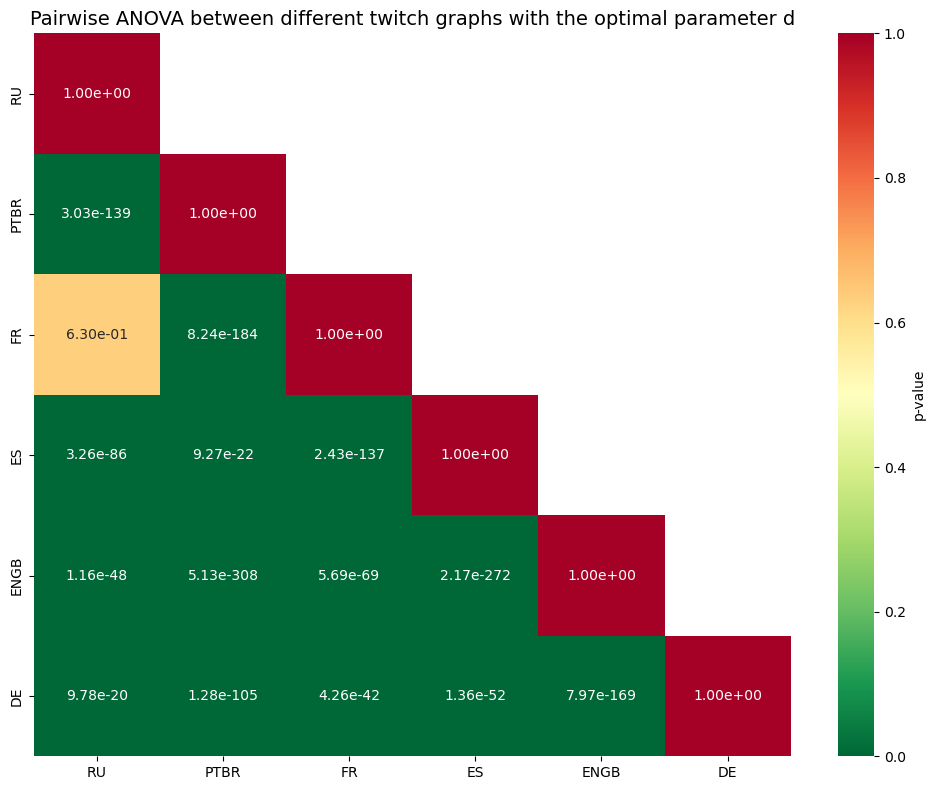

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a mask for the upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(P, dtype=bool), k=1)

# Create a heatmap of the p-values (triangular)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(P, annot=P_fmt, fmt='', cmap='RdYlGn_r', 
            xticklabels=regions, yticklabels=regions,
            cbar_kws={'label': 'p-value'}, ax=ax, mask=mask)

ax.set_title('Pairwise ANOVA between different twitch graphs with the optimal parameter d', fontsize=14)
plt.tight_layout()
plt.show()
